In [1]:
# Generelle moduler og funksjonsbeskrivelser brukt i forelesningen
from numpy import sin, cos, pi, exp
import scipy.signal as sig
import numpy.fft as fft
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

%matplotlib ipympl

<img src="figures/NTNU_logo_vertical.svg" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# Introduction to Digital Filters

* **Course AIS2201 - Signalbehandling**
* **Week 41, 2025**
* **Lecturer: Kai Erik Hoff**


# Topics

* Digital filters as a concept
* Desired properties (LTI)
* Discrete LTI-systems (the difference equation)
* IIR filters summarized
    * Exponential averager is a IIR filter
    * Digital IIR filters created by discretizing continuous systems
* FIR filters
    * Coefficients = impulse response
    * Filtering = convolving impulse respone & signal

# Group discussion

$$y[n] = \frac{1}{16} \cdot x[n] + \frac{1}{4} \cdot x[n-2] + \frac{3}{8} \cdot x[n-4] + \frac{1}{4} \cdot x[n-6] + \frac{1}{16} \cdot x[n-8] \tag{1}$$

1. How can we figure out what equation $1$ does?

2. How can we make a program (e.g. in Python) do what equation $1$ describes?

# What is a filter?

* In a signal processing context:
    * Attenuates unwanted frequency components in a signal
    * Amplifies/preserves desired frequency components in a signal

<img src="figures/FilterIllustration.png" style="margin-left:15%" width="60%"/>

# Desirable properties


* Sinusoid in $\Rightarrow$ sinusoid out
    * Basic requirement for frequency analysis of a system
    * Inherent to the definition of a filter

* Frequency components affected *independently*
    * A lowpass filter should attenuate high-frequency components regardless of whether a low-frequency component is present in the signal as well.

* The above conditions require the digital filter to be ***Linear*** and ***Time-Invariant***

# Linearity

* Given $y[n] = F(x[n])$, where $F$ denotes the system's function, the system described by $F$ is linar if it satisfies the following conditions:


    * **Additivity:**
    $$F(x_1[n] + x_2[n]) = F(x_1[n])+F(x_2[n])$$
    
    * **Homogeneity:**
    $$F(\alpha \cdot x[n]) = \alpha \cdot F(x[n])$$

## Linearity Illustrated:

<img src="figures/Fig7_Additivity_v2.png" style="width: 50%" />

# Time-Invariance


* Given $y[n] = F(x[n])$ where $F$ denotes the system's function, adding a delay to the input should produce the same delay at the output:
$$F(x[n-N]) = y[n-N]$$
<br>
<img src="figures/Fig8_TimeInv.png" style="width: 60%" />

# Digital LTI-systems

* Composed of a limited set of linear and time-invariant mathematical operations:

#### Summation
<div style="width:80%">
<img src="figures/summation.svg" style="float:right; width:30%"/>
$$y[n] = x_1[n] \pm x_2[n]$$     
</div>

#### Scalar multiplication
<div style="width:80%">
<img src="figures/multiply.svg" style="float:right; width:30%"/>
$$y[n] = x[n] \cdot \alpha$$     
</div>

#### Delay (time shifting)
<div style="width:80%">
<img src="figures/delay.svg" style="float:right; width:30%"/>
$$y[n] = x[n-1]$$     
</div>

# Final requirement: causality

* Filter output may **not** depend on future sample values
    * Example: $y[n] = x[n+1]$

* Essential for real-time systems

  
<img src="figures/FilterAnimation.gif" width="40%"  />

* Filters retroactively processing full data recordings (eg. audio files) may be non-causal

# Discrete-time Causal LTI-systems:

* Described using a ***difference equation***
$$\sum_{k=0}^{M} a_k \cdot y[n-k] = \sum_{k=0}^{N} b_k \cdot x[n-k]$$
    * The series $a_k$ and $b_k$ are known as *filter coefficients*

# Digital filter properties: *The Impulse Response*

<img src="figures/impulse_response.svg" style="width: 60%; margin-left: 200px" />

* The mathematical properties of a digital filter which is both linear and time-invariant are contained entirely within it's impulse response.

<!--
* Premiss for LTI-system:
    * *Dersom systemets reaksjon til en deltapuls $\delta[n]$ er kjent, er det mulig å predikere hvordan systemet vil reagere på alle mulige inngangssignal.*
* Utgangssignalet til et LTI-system gitt en impuls $\delta[n]$ som inngangssignal kalles impulsresponsen $h[n]$ til systemet.
-->

# *Recap: the discrete delta pulse*

<img src="figures/Fig1_dn.svg" style="width: 40%; margin-left: 10%; margin-right:10%" align="right"/>

* **Definiton:**

$$
\Large
\delta[n] = 
\begin{cases}
1, n=0\\
0, n\neq 0
\end{cases}
$$


# Filter categories

### **I**nfinite **I**mpulse **R**esponse (IIR)
* Uses previous values of both input $x[n-k]$ and output $y[n-k]$ as basis for calculating the updated output value $y[n]$.
* General algorithm for IIR filters:

$$\Large y[n] = \frac{1}{a_0}\cdot \left(\sum_{k=0}^{N} b_k \cdot x[n-k] - \sum_{k=1}^{M}a_k\cdot  y[n-k] \right)$$

### **F**inite **I**mpulse **R**esponse (FIR)
* Uses *only* previous input values $x[n-k]$ as a basis for calculating
* General algorithm for FIR filtrs:
$$\Large y[n] = \sum_{k=0}^{N} b_k \cdot x[n-k]$$

# IIR filter system diagram

<img src="figures/df1.svg" style="margin-left:25%;width:50%"/>

* Filter order: $\max(M, N)$
    * *How many samples into the past does the IIR filter need to "remember"*

## Example of a IIR filter: *exponential averager*

* The output is a weighted sum of the current input $x[n]$ and the previous output $y[n-1]$:
$$y[n] = \alpha \cdot x[n] + (1-\alpha) \cdot y[n-1]$$

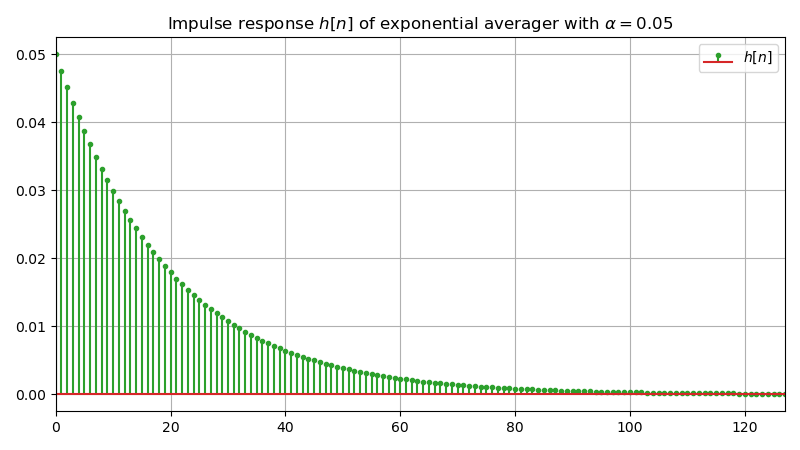

In [2]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt 
def exponential_averaging(x: np.ndarray, alpha=0.1):
    """
    Function to perform exponential averaging on an input signal 'x'. 
    Filtering function: y[n] = alpha*x[n] + (1-alpha)*y[n-1]

    Parameters:
    - x: Array representing input signal
    - alpha: Smoothing factor 0 < alpha < 1

    Returns:
    - y: Array containing filtered output
    """
    L = len(x)  # length of signal
    y = np.zeros(L)
    for n in range(L):
        y[n] = alpha*x[n] + (1-alpha)*y[n-1]
    return y


N = 128
dn = np.zeros(N)
dn[0] = 1
hn = exponential_averaging(dn, alpha=0.05)

plt.close(1); plt.figure(1)
plt.title("Impulse response $h[n]$ of exponential averager with $\\alpha=0.05$")
plt.stem(hn, markerfmt=".", linefmt="C2", label="$h[n]$")
plt.legend(loc="upper right")

* Categorized as an IIR filter because $h[n]$ will never be *precisely* equal to $0$ for any $n\geq0$

# Designing IIR filters *(as covered in AIS2102 discretization module)*

1. Determine desired filter response properties (filter order, lowpass/highpass, cutoff frequency etc...)

In [3]:
f_c = 100 # Cutoff frequency (Hz)
filter_type = "lowpass"
filter_order = 4

2. Design an *analog* filter ([butterworth](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html#scipy.signal.butter), [chebyshev](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cheby1.html#scipy.signal.cheby1), [bessel](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bessel.html#scipy.signal.bessel) etc...) with the desired response

Text(0, 0.5, 'Filter gain (dB)')

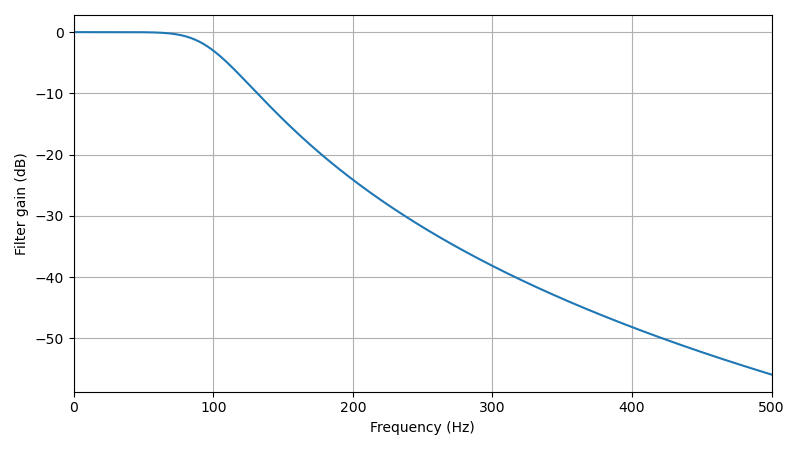

In [4]:
b, a = sig.butter(filter_order, f_c*2*np.pi, filter_type, analog=True)
w, Hw = sig.freqs(b, a, worN=np.pi*2*np.linspace(0, 500, 513))
plt.close(2); plt.figure(2)
plt.plot(w/2/np.pi, 20*np.log10(np.abs(Hw)))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Filter gain (dB)")

3. *Discretize* the analog filter, typically using Tustin's method (aka. Bilinear Transform aka. trapezoidal integration) with pre-warping.
    * *Tustin's method is preferred for DSP applications because it allows us to retain corner frequencies precisely*

(-100.0, 12.005490632705648)

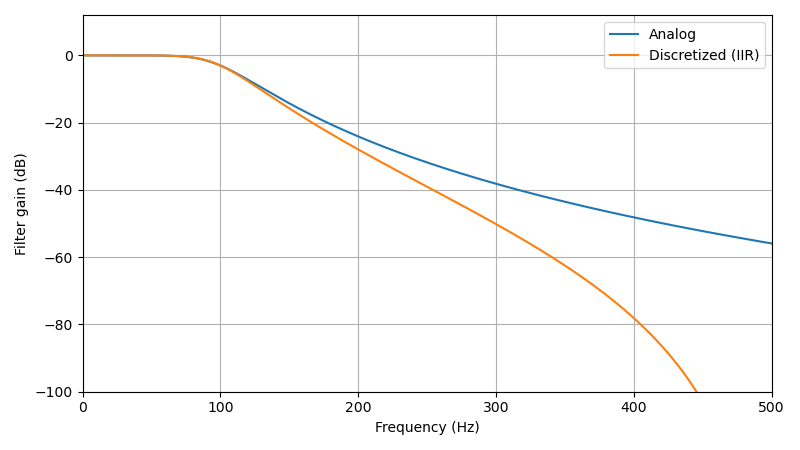

In [5]:
fs = 1_000 # samples / second
fs_warped = (np.pi*f_c)/np.tan(np.pi*f_c/fs)  # Perform pre-warping of cutoff frequency
b_d, a_d = sig.bilinear(b, a, fs=fs_warped)   # Discretize using trapezoidal integration
f_d, Hf_d = sig.freqz(b_d, a_d, fs=fs)

plt.close(3); plt.figure(3)
plt.plot(w/2/np.pi, 20*np.log10(np.abs(Hw)), label="Analog")
plt.plot(f_d, 20*np.log10(np.abs(Hf_d)), label="Discretized (IIR)")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Filter gain (dB)"); plt.ylim(ymin=-100)

## Signal filtering using `scipy`:

* General function for filtering with LTI-systems: [`scipy.signal.lfilter(b, a, x)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html).
* Function Parameters:
    * `b`: Filter coefficients $b_k$
    * `a`: Filter coefficients $a_k$
    * `x`: Array containing input signal $x[n]$ to be filtered.


(0.0, 127.0)

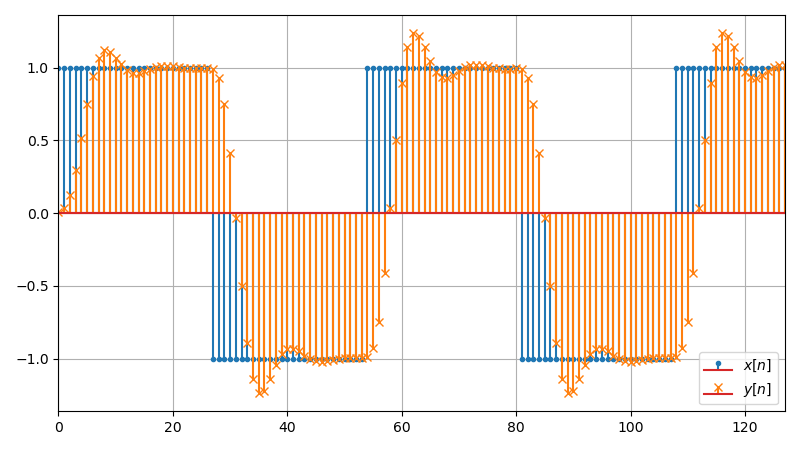

In [6]:
# Example using discretized filter from perevious slide
import scipy.signal as sig

# Generate input square wave signal
N = 128
n = np.arange(N)
xn = sig.square(np.pi/27*n)

# Perform filtering
yn = sig.lfilter(b_d, a_d, xn)

# Display input and output signal
plt.figure()
plt.stem(xn, markerfmt='.', label="$x[n]$")
plt.stem(yn, markerfmt="x", linefmt="C1", label="$y[n]$")
plt.legend(loc="lower right")
plt.xlim([0, N-1])

Mathematically, an IIR filter is identical to a discrete controller or a discretized system model. The only difference is mathematical notation, and the domain of application (the discrete controller is inserted into a closed loop, while the terminology "IIR filter" typically refers to a stand-alone "open-loop" system for filtering e.g. music).

Since the theory behind IIR filters and discrete control theory is the same, IIR filters will not play a major role in this course's curriculum. If you wish a refresher, chapter 6 covers this topic in detail.

# What is a FIR filter?


 


* **FIR** - **F**inite **I**mpulse **R**esponse

* Describes a digital filter which calculates the output $y[n]$ based *only* on a linear combination of the input values $x[n]$ at various samplingtimes.

* Entirely described by the filter coefficients $b_k$

* Can be viewed as a Discrete LTI-system where $a_k$ equals:
$$
a_k = 
\begin{cases}
1,\ \ \  k = 0\\
0,\ \ \  k \neq 0
\end{cases}
$$

* Difference equation for FIR filters:
### $$ y[n] = \sum_{k=0}^{N} b_k \cdot x[n-k]$$

* $N$ denotes the *filter order*
    * Determines how many samples "back in time" the FIR filter needs to keep samples in the buffer.

* Mathematically much simpler to work with than a IIR filter

# FIR filter system diagram


<br>
<img src="figures/tapped_delay_line.svg" style="width: 60%; margin-left: 10%" />




* FIR filters commonly referred to as *tapped delay line* filters

* Number of "taps" ($M=N+1$) are a more common metric for size of filter than the filter order

## Example of a FIR filter: *moving average filter*
* The output $y[n]$ is the ***mean*** of the $M$ most recent input values $x[n-k], k \in \{0, 1, \ldots , M-1\}$.

$$y[n] = \frac{1}{M} \sum_{k=0}^{M-1} x[n-k]$$



(0.0, 127.0)

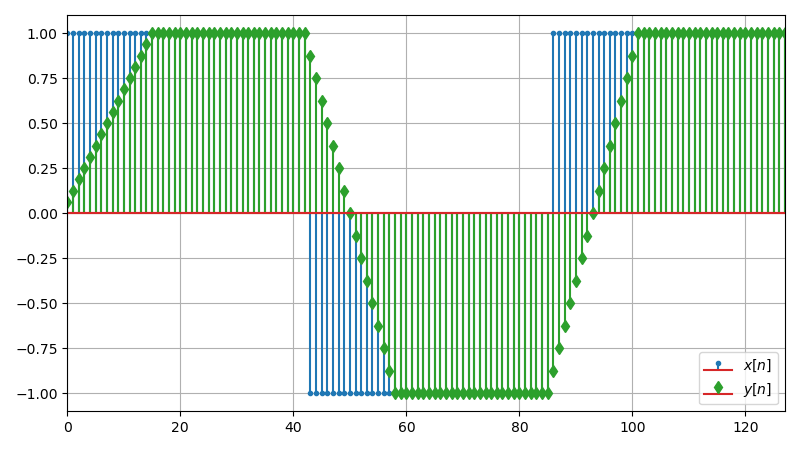

In [10]:
def moving_average(x: np.ndarray, M=16):
    """
    Function to perform moving average filtering of an input signal 'x'.
    Filtering function: y[n] = (x[n] + x[n-1] + ... + x[n-K+1])/K

    Parameters:
    - x: Array representing input signal
    - K: Length of averaging "window"

    Returns:
    - y: Array containing filtered output
    """
    L = len(x)
    y = np.zeros(L)
    for n in range(L):
        y[n] = np.sum(x[n:max(n-M,0):-1])/M
    return y


N = 128
n = np.arange(N)
xn = sig.square(2*np.pi*1.5*n/N)
#yn = moving_average(xn, M=16)
yn = sig.lfilter(np.ones(16)/16, [1], xn)

plt.figure()
plt.stem(xn, markerfmt='.', label="$x[n]$")
plt.stem(yn, markerfmt="d", linefmt="C2", label="$y[n]$")
plt.legend(loc="lower right")
plt.xlim([0, N-1])

## Quiz-question:

* What are the filter coefficients $b_k$ of a $M=8$-tap moving average filter?

# Let's return to our mystery equation:

$$y[n] = \frac{1}{16} \cdot x[n] + \frac{1}{4} \cdot x[n-2] + \frac{3}{8} \cdot x[n-4] + \frac{1}{4} \cdot x[n-6] + \frac{1}{16} \cdot x[n-8] \tag{1}$$

* Code to process signal according to equation $1$:

In [13]:
def filter_signal(x):
    y= []
    for n in range(len(x)):
        yn = 1/16*x[n]
        for k, bk in zip([2, 4, 6, 8], [1/4, 3/8, 1/4, 1/16]):
            if n - k >= 0:
                yn += x[n-k]*bk
        y.append(yn)
    return y

* "Manual" analysis of filter:

interactive(children=(IntSlider(value=2, description='f', max=50, min=2, step=2), Output()), _dom_classes=('wi…

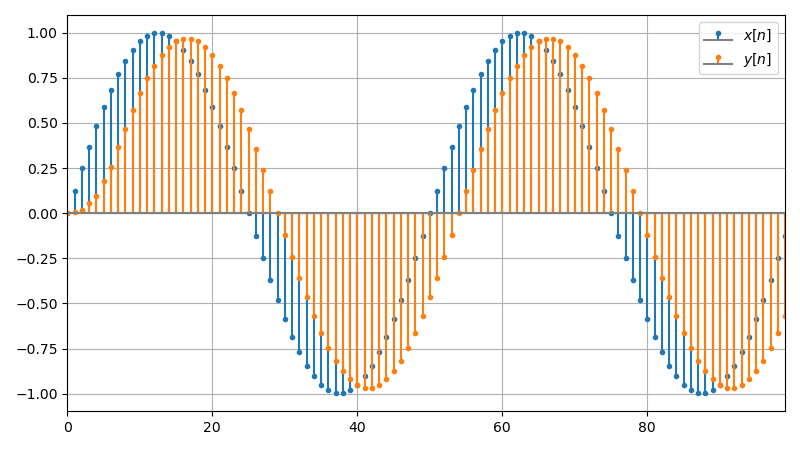

In [15]:
from ipywidgets import interact, IntSlider
fs = 100
plt.subplots(1,1)
@interact(f = IntSlider(min=2, max=50, step=2, value=2))
def display_xn_yn(f):
    w = 2*np.pi*f/fs
    n = np.arange(fs)
    xn = np.sin(w*n)
    yn = filter_signal(xn)
    plt.cla()
    plt.stem(n, xn, basefmt="grey", linefmt="C0", markerfmt=".C0", label="$x[n]$")
    plt.stem(n, yn, basefmt="grey", linefmt="C1", markerfmt=".C1", label="$y[n]$")
    plt.legend()

# Questions?